# Waterbody Polygons <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** 
[wofs_summary](https://explorer.sandbox.dea.ga.gov.au/wofs_summary)
* **Special requirements:**
    - [GEODATA COAST 100K 2004
](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/61395) coastline polygons
    - [Australian Bureau of Statistics Statistical Area 3 shapefile (2016)](http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.001July%202016?OpenDocument#Data)

## Background
On average, the Australian Government invests around half a billion dollars a year in monitoring, protecting and enhancing Australia's land, coasts and oceans. DEA provides near real-time satellite information which can be used by government to better target these investments.

Water is among one the most precious natural resources and is essential for the survival of life on Earth. Within Australia, the scarcity of water is both an economic and social issue. Water is required not only for consumption but for industries and environmental ecosystems to function and flourish. 

With the demand for water increasing, there is a need to better understand our water availability to ensure we are managing our water resources effectively and efficiently.  

Digital Earth Australia (DEA)'s [Water Observations from Space (WOfS) dataset](https://www.sciencedirect.com/science/article/pii/S0034425715301929), provides a water classified image of Australia approximately every 16 days. These individual water observations have been combined into a [WOfS summary product](https://explorer.sandbox.dea.ga.gov.au/wofs_summary), which calculates the frequency of wet observations (compared against all clear observations of that pixel), over the full 30 year satellite archive. 

The WOfS summary product provides valuable insights into the persistence of water across the Australian landscape on a pixel by pixel basis. While knowing the wet history of a single pixel within a waterbody is useful, it is more useful to be able to map the whole waterbody as a single object. 

## Description

This notebook reimplements the polygon generation of DEA Waterbodies to work on a small area using the DEA Datacube.

## Getting started

To run this analysis, work through this notebook starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
from pathlib import Path

import rasterio.features
from shapely.geometry import Polygon, shape, mapping, MultiPolygon
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path
import math
import geohash as gh
import re
import datacube
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from waterbodies_aux import xr_vectorize, xr_rasterize, get_waterbodies

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


## Analysis parameters

This section lets you set parameters for the analysis.

<a id='wetnessThreshold'></a>
### How frequently wet does a pixel need to be to be included?
The value/s set here will be the minimum frequency (as a decimal between 0 and 1) that you want water to be detected across all analysis years before it is included. 

E.g. If this was set to 0.10, any pixels that are wet *at least* 10% of the time across all valid observations will be included. If you don't want to use this filter, set this value to 0.

Following the exploration of an appropriate wetness threshold for DEA Waterbodies ([see here](DEA_Waterbodies_supplement/DEAWaterbodiesThresholdSensitivityAnalysis.ipynb)), we choose to set two thresholds here. The code is set up to loop through both wetness thresholds, and to write out two temporary shapefiles. These two shapefiles with two separate thresholds are then used together to combine polygons from both thresholds later on in the workflow.

Polygons identified by the secondary threshold that intersect with the polygons generated by the primary threshold will be extracted, and included in the final polygon dataset. This means that the **location** of polygons is set by the primary threshold, but the **shape** of these polygons is set by the secondary threshold.

Threshold values need to be provided as a list of either one or two floating point numbers. If one number is provided, then this will be used to generate the initial polygon dataset. If two thresholds are entered, the **first number becomes the secondary threshold, and the second number becomes the primary threshold**. If more than two numbers are entered, the code will generate an error below. 

In [2]:
minimum_wet_percentage = [0.05, 0.1]

<a id='size'></a>
### How big/small should the polygons be?
This filtering step can remove very small and/or very large waterbody polygons. The size listed here is in m2. A single pixel in Landsat data is 25 m X 25 m = 625 m2. 

**MinSize**

E.g. A minimum size of 6250 means that polygons need to be at least 10 pixels to be included. If you don't want to use this filter, set this value to 0.

**MaxSize**

E.g. A maximum size of 1 000 000 means that you only want to consider polygons less than 1 km2. If you don't want to use this filter, set this number to `math.inf`. 

*NOTE: if you are doing this analysis for all of Australia, very large polygons will be generated offshore, in the steps prior to filtering by the Australian coastline. For this reason, we have used a `MaxSize` = Area of Kati Thanda-Lake Eyre. This will remove the huge ocean polygons, but keep large inland waterbodies that we want to map.*

In [3]:
min_area_m2 = 3125  # 5 pixels
max_area_m2 = 5000000000  # approx area of Kati Thanda-Lake Eyre

<a id='valid'></a>
### Filter results based on number of valid observations

The total number of valid WOfS observations for each pixel varies depending on the frequency of clouds and cloud shadow, the proximity to high slope and terrain shadow, and the seasonal change in solar angle. 

The `count_clear` parameter within the [`wofs_summary`](https://explorer.sandbox.dea.ga.gov.au/wofs_summary) data provides a count of the number of valid observations each pixel recorded over the analysis period. We can use this parameter to mask out pixels that were infrequently observed. 
If this mask is not applied, pixels that were observed only once could be included if that observation was wet (i.e. a single wet observation means the calculation of the frequency statistic would be (1 wet observation) / (1 total observation) = 100% frequency of wet observations).

Here we set the minimum number of observations to be 128 (roughly 4 per year over our 32 year analysis). Note that this parameter does not specify the timing of these observations, but rather just the **total number of valid observations** (observed at any time of the year, in any year).

In [4]:
min_valid_observations = 128

This filter can be applied before or after aggregating polygons. Version 1 of Waterbodies applies the filter before. If you would like to apply this filter *after* the polygons have been aggregated, specify `False` here:

In [5]:
apply_min_valid_observations_first = True

### Mask urban areas

WOfS has a known limitation where it considers the shadows of tall buildings to be water. We can mask the CBDs of major areas based on the ABS SA3 regions:

|SA3_CODE1|SA3_NAME16|
|---------|----------|
|11703    |Sydney Inner City|
|20604    |Melbourne City|
|30501    |Brisbane Inner|
|30901    |Broadbeach - Burleigh|
|30910    |Surfers Paradise|
|40101    |Adelaide City|
|50302    |Perth City|

Set `urban_mask = True` to enable this mask, or `False` to disable it.

In [6]:
urban_mask = True

In [7]:
sa3_urban_areas = [11703, 20604, 30501, 30901, 30910, 40101, 50302]

If you want to use the urban mask, then you have to specify the location of the SA3 shapefile:

In [8]:
sa3_filepath = 'SA3_2016_AUST.shp'

### Splitting large polygons

There are currently two methods for splitting large polygons:

- Use the Polsby-Popper test, then erode/dilate
- Don't do that

Choose one of those:

In [9]:
handle_large_polygons = 'erode-dilate-v2'

In [10]:
# Check that's a valid method for handling.
large_polygon_options = {'erode-dilate-v1', 'erode-dilate-v2', 'nothing'}
assert handle_large_polygons in large_polygon_options

You also need to specify a threshold for the Polsby-Popper test above which polygons won't be split (DEA Waterbodies uses 0.005):

In [11]:
pp_thresh = 0.005

<a id='Tiles'></a>
### Set up the input datasets for the analysis

In [12]:
# Lake Will and surrounds
# ylim = [-41.77726, -41.71853]
# xlim = [145.89853, 146.01644]

# Lake Burbury
# ylim = [-42.22063, -42.01168]
# xlim = [145.59086, 145.79827]

# Esperance
ylim = [-33.93368, -33.77032]
xlim = [121.77200, 122.00242]

# Menindee Lakes
# ylim = [-32.74068, -32.03379]
# xlim = [141.93057, 142.93699]

# Cobdogla
# ylim = [-34.30416606421627, -34.14519760492369]
# xlim = [140.29111862182236, 140.51290512084577]

### Output filename

Specify the output base filename:

In [13]:
base_filename = 'waterbodies'

## Generate the first polygon dataset

This is the first set of polygons with no filtering.

Remove any previous runs of this code, and set up an output directory for the new results.

In [14]:
%%bash
rm -rf _wb_outputs
mkdir _wb_outputs

In [15]:
intermediate_wb_path = Path('_wb_outputs/')

Check we have set all our analysis parameters correctly

In [16]:
# First, test whether the wetness threshold has been correctly set
if len(minimum_wet_percentage) == 2:
    print(
        f'We will be running a hybrid wetness threshold. Please ensure that the major threshold is \n'
        f'listed second, with the supplementary threshold entered first.'
        f'**You have set {minimum_wet_percentage[-1]} as the detection threshold,** \n'
        f'**with {minimum_wet_percentage[0]} set as the extent threshold.**')
elif len(minimum_wet_percentage) == 1:
    print(
        f'You have not set up the hybrid threshold option. If you meant to use this option, please \n'
        f'set this option by including two wetness thresholds in the `AtLeastThisWet` variable above. \n'
        f'The wetness threshold we will use is {minimum_wet_percentage}.')
else:
    raise ValueError(
        f'There is something wrong with your entered wetness threshold. Please enter a list \n'
        f'of either one or two numbers. You have entered {minimum_wet_percentage}. \n'
        f'See above for more information')

We will be running a hybrid wetness threshold. Please ensure that the major threshold is 
listed second, with the supplementary threshold entered first.**You have set 0.1 as the detection threshold,** 
**with 0.05 set as the extent threshold.**


Load up WOfS:

In [17]:
# Set up the datacube to get DEA data.
dc = datacube.Datacube(app='WaterbodyPolygons')

# Some query parameters.
dask_chunks = {'x': 3000, 'y': 3000, 'time': 1}
resolution = (-25, 25)  # This is the resolution of WOfS, which changes depending on which collection you use.

# Then load the WOfS summary of clear/wet observations:
wofs_ = dc.load('wofs_summary', x=xlim, y=ylim, dask_chunks=dask_chunks)
wofs = wofs_.isel(time=0)
# And set the no-data values to nan:
wofs = wofs.where(wofs != -1)

# Also load the all-time summary:
wofs_filtered_summary = dc.load('wofs_filtered_summary', x=xlim, y=ylim, dask_chunks=dask_chunks).isel(time=0)

Then load the mask for filtering minimum valid observations. We can compute this now even if we don't want to aggregate after filtering, because we'll still need it later.

In [18]:
# Filter pixels with at least min_valid_observations times.
wofs_valid_filtered = wofs.count_clear >= min_valid_observations

Now we can do our first pass of polygon detection.

In [19]:
for threshold in minimum_wet_percentage:
    # Remove any pixels that are wet < AtLeastThisWet% of the time
    wofs_filtered = wofs_filtered_summary.wofs_filtered_summary > threshold

    # Now find pixels that meet both the minimum valid observations and wetness percentage criteria
    # Change all zeros to NaN to create a nan/1 mask layer
    # Pixels == 1 now represent our water bodies
    if apply_min_valid_observations_first:
        wofs_filtered = wofs_filtered.where(wofs_filtered & wofs_valid_filtered)
    else:
        wofs_filtered = wofs_filtered.where(wofs_filtered)
    
    # Vectorise the raster.
    polygons = xr_vectorize((wofs_filtered == 1).values, crs='EPSG:3577', transform=wofs_filtered_summary.rio.transform())
    polygons = polygons[polygons.attribute == 1].reset_index(drop=True)

    # Combine any overlapping polygons
    polygons = polygons.geometry.buffer(0).unary_union

    # Turn the combined multipolygon back into a geodataframe
    polygons = gp.GeoDataFrame(
        geometry=[poly for poly in polygons])
    # We need to add the crs back onto the dataframe
    polygons.crs = 'EPSG:3577'

    # Calculate the area of each polygon again now that overlapping polygons
    # have been merged
    polygons['area'] = polygons.area
    
    # Save the polygons to a shapefile
    filename = intermediate_wb_path / f'{base_filename}_raw_{threshold}.shp'
    polygons.to_file(filename)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


We can then look at all of the polygons we have found so far, from which we will extract our waterbodies:

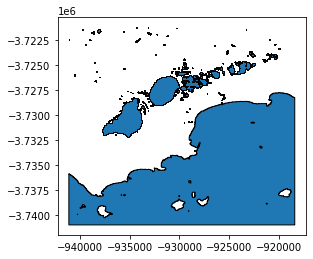

In [20]:
gp.read_file(filename).plot(edgecolor='k')

<a id='Filtering'></a>

## Filter the merged polygons by area, coastline, CBD, and wetness


### Filtering by area

In [21]:
if len(minimum_wet_percentage) == 2:
    polygons = gp.read_file(intermediate_wb_path / f'{base_filename}_raw_{minimum_wet_percentage[1]}.shp')
else:
    polygons = gp.read_file(intermediate_wb_path / f'{base_filename}_raw_{minimum_wet_percentage[0]}.shp')

In [22]:
# Filter polygons by size.
polygons = polygons[(polygons['area'] >= min_area_m2) & (polygons['area'] <= max_area_m2)]

We have now removed all the very small and very large polygons:

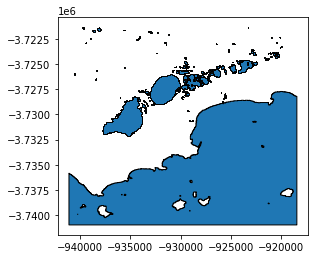

In [23]:
polygons.plot(edgecolor='k')

### Filter by coastline

Load the coastline:

In [24]:
coastline = dc.load('geodata_coast_100k', output_crs='EPSG:3577', x=xlim, y=ylim, resolution=resolution)

Mark any polygon that intersects with the sea as ocean.

In [25]:
# Set up a column to fill the raster with.
polygons['polygon_idx'] = range(1, len(polygons) + 1)
# Then rasterise the polygons to find the area they cover.
raster = xr_rasterize(polygons, wofs, attribute_col='polygon_idx')
# Multiply the ocean mask by the polygon_idx at each pixel to find which values of polygon_idx overlap with water and therefore are ocean.
ocean_ids = pd.unique((raster * (coastline.land == 0)).values.ravel())

Then we can exclude the ocean.

In [26]:
polygons = polygons[~polygons.polygon_idx.isin(ocean_ids)]

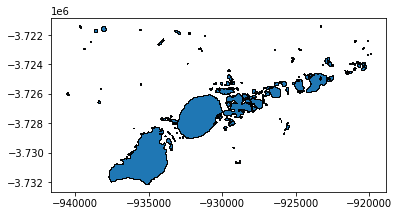

In [27]:
polygons.plot(antialiased=True, edgecolor='k')

### Filter CBD

Remove polygons that intersect with major cities if `urban_mask`.

In [28]:
if urban_mask:
    # Read in the SA3 regions.
    sa3 = gp.read_file(sa3_filepath)
    sa3['SA3_CODE16'] = sa3['SA3_CODE16'].astype(int)
    # Get all the regions which are CBDs.
    cbds = sa3.set_index('SA3_CODE16').loc[sa3_urban_areas]
    # Then remove all polygons that intersect with the CBDs.
    city_overlay = gp.overlay(polygons, cbds.to_crs('EPSG:3577'))
    polygons = polygons[~polygons.polygon_idx.isin(city_overlay.polygon_idx)]

### Combine detected polygons with their maximum extent boundaries

In [29]:
# Check for hybrid wetness thresholds
if len(minimum_wet_percentage) == 2:
    # Note that this assumes that the thresholds have been correctly entered into the 'minimum_wet_percentage'
    # variable, with the extent threshold listed first.
    lower_threshold = gp.read_file(
        intermediate_wb_path / f'{base_filename}_raw_{minimum_wet_percentage[0]}.shp')
    lower_threshold['area'] = pd.to_numeric(lower_threshold.area)
    # Filter out those pesky huge polygons
    lower_threshold = lower_threshold.loc[(lower_threshold['area'] <= max_area_m2)]
    lower_threshold['lt_index'] = range(len(lower_threshold))
    # Pull out the polygons from the extent shapefile that intersect with the detection shapefile
    overlay_extent = gp.overlay(polygons, lower_threshold)
    lower_threshold_to_use = lower_threshold.loc[overlay_extent.lt_index]
    # Combine the polygons
    polygons = gp.GeoDataFrame(pd.concat([lower_threshold_to_use, polygons], ignore_index=True))
    # Merge overlapping polygons
    polygons = polygons.unary_union
    # Back into individual polygons
    polygons = gp.GeoDataFrame(crs='EPSG:3577', geometry=[polygons]).explode()

In [30]:
# Get rid of the multiindex that explode added:
polygons = polygons.reset_index(drop=True)

In [31]:
# Add area, perimeter, and polsby-popper columns:
polygons['area'] = polygons.area
polygons['perimeter'] = polygons.length
polygons['pp_test'] = polygons.area * 4 * math.pi / polygons.perimeter ** 2

In [32]:
# Dump the merged polygons to a file:
polygons.to_file(intermediate_wb_path / f'{base_filename}_merged.shp')
polygons.to_file(intermediate_wb_path / f'{base_filename}_merged.geojson', driver='GeoJSON')

We now have the 5% extent for all polygons detected at a 10% level:

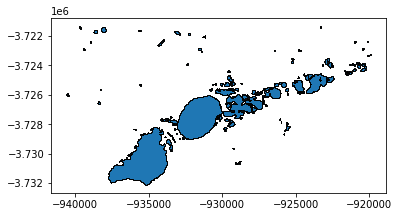

In [33]:
gp.read_file(intermediate_wb_path / f'{base_filename}_merged.shp').plot(edgecolor='k')


### Dividing up very large polygons

The size of polygons is determined by the contiguity of waterbody pixels through the landscape. This can result in very large polygons, e.g. where rivers are wide and unobscured by trees, or where waterbodies are connected to rivers or neighbouring waterbodies. The image below shows this for the Menindee Lakes, NSW. The relatively flat terrain in this part of Australia means that the 0.05 wetness threshold results in the connection of a large stretch of river and the individual lakes into a single large polygon that spans 154 km. This polygon is too large to provide useful insights into the changing water surface area of the Menindee Lakes, and needs to be broken into smaller, more useful polygons.

We do this by applying the [Polsby-Popper test (1991)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2936284). The Polsby-Popper test is an assessment of the 'compactness' of a polygon. This method was originally developed to test the shape of congressional and state legislative districts, to prevent gerrymandering. 

The Polsby-Popper test examines the ratio between the area of a polygon, and the area of a circle equal to the perimeter of that polygon. The result falls between 0 and 1, with values closer to 1 being assessed as more compact.

\begin{align*}
PPtest = \frac{polygon\ area * 4\pi}{polygon\ perimeter^2}
\end{align*}

The Menindee Lakes polygon has a PPtest value $\approx$ 0.00. 

We selected all polygons with a `PPtest` value <=0.005. This resulted in a subset of 186 polygons continent-wide.

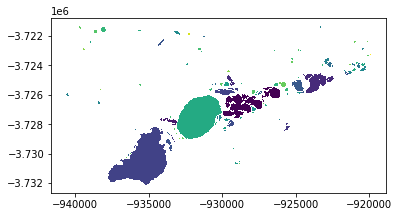

In [34]:
polygons.plot(column='pp_test')

How many polygons in our test region fall below the Polsby-Popper threshold?

In [35]:
(polygons.pp_test <= pp_thresh).sum()

0

The 186 polygons were buffered with a -50 meter (2 pixel) buffer to separate the polygons where they are connected by two pixels or less. This allows us to split up these very large polygons by using natural thinning points. The resulting negatively buffered polygons was run through the `multipart to singlepart` tool in QGIS, to give the now separated polygons unique IDs. 

These polygons were then buffered with a +50 meter buffer to return the polygons to approximately their original size. These final polygons were used to separate the 186 original polygons identified above.

The process for dividing up the identified very large polygons varied depending on the polygon in question. Where large waterbodies (like the Menindee Lakes) were connected, the buffered polygons were used to determine the cut points in the original polygons. Where additional breaks were required, the [Bureau of Meteorology's Geofabric v 3.0.5 Beta (Suface Hydrology Network)](ftp://ftp.bom.gov.au/anon/home/geofabric/) `waterbodies` dataset was used as an additional source of information for breaking up connected segments.

The buffering method didn't work on large segments of river, which became a series of disconnected pieces when negatively and positively buffered. Instead, we used a combination of tributaries and man-made features such as bridges and weirs to segment these river sections.

If `handle_large_polygons = 'erode-dilate-v1`, then we will attempt to replicate DEA Waterbodies as above. If it's `erode-dilate-v2`, we'll do a slightly different method designed for full automation, but this is not yet implemented. If it's `nothing` we'll do nothing.

In [36]:
if handle_large_polygons == 'erode-dilate-v1':
    needs_buffer = polygons[polygons.pp_test <= pp_thresh]
    unbuffered = needs_buffer.buffer(-50)
    unbuffered = unbuffered.explode().reset_index(drop=True).buffer(50)
    unbuffered = gp.GeoDataFrame(geometry=unbuffered, crs='EPSG:3577')
    unbuffered['area'] = unbuffered.area
    unbuffered['perimeter'] = unbuffered.length
    unbuffered['pp_test'] = unbuffered.area * 4 * math.pi / unbuffered.perimeter ** 2
    polygons = pd.concat([polygons[polygons.pp_test > pp_thresh], unbuffered], ignore_index=True)

**TODO: This doesn't quite match DEA Waterbodies. Need to cut based on the polygons instead. coastal-waterbodies also contains some ideas for handling these kinds of networks.**

v2 is more expensive but doesn't require manual intervention. Start with the original polygon set $P$. Unbuffer by a few pixels and then buffer by one extra pixel, so we have a slightly larger version of the original but split up and without small polygons; call this $Q$. Subtract this from the original polygon set to obtain the subtracted set $P - Q$. Subtract _this_ set to obtain $P - (P - Q)$, noting that this isn't just $P$ because these are set operations. This gives a non-rounded version of the original large polygons that have been split up. We then just need to add back in the small bits that were chopped off, which we can do by assigning each to their nearest neighbour.

In [37]:
if handle_large_polygons == 'erode-dilate-v2':
    splittable = polygons[polygons.pp_test <= pp_thresh]
    if len(splittable) >= 1:
        unbuffered = splittable.buffer(-100)
        buffered = unbuffered.buffer(125)
        subtracted = gp.overlay(splittable, gp.GeoDataFrame(geometry=[buffered.unary_union], crs=splittable.crs), how='difference').explode().reset_index(drop=True)
        resubtracted = gp.overlay(splittable, subtracted, how='difference').explode().reset_index(drop=True)

        # Assign each chopped-off bit of the polygon to its nearest big neighbour.
        unassigned = np.ones(len(subtracted), dtype=bool)
        recombined = []
        for i, poly in resubtracted.iterrows():
            mask = subtracted.exterior.intersects(poly.geometry.exterior) & unassigned
            neighbours = subtracted[mask]
            unassigned[mask] = False
            poly = poly.geometry.union(neighbours.unary_union)
            recombined.append(poly)    

        # All remaining polygons are not part of a big polygon.
        results = pd.concat([gp.GeoDataFrame(geometry=recombined), subtracted[unassigned], polygons[polygons.pp_test > pp_thresh]], ignore_index=True)

        polygons = results.explode().reset_index(drop=True)

In [38]:
if handle_large_polygons == 'nothing':
    print('Not splitting large polygons')

Here is the most complex polygon after the splitting step:

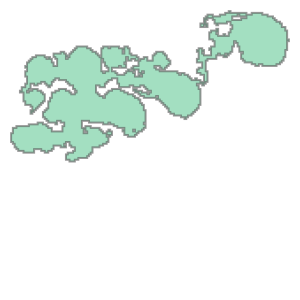

In [39]:
polygons.iloc[polygons.pp_test.argmin()].geometry

## Make sure every polygon has a minimum number of observations

Similar to how we applied the ocean mask, we will now remove all polygons that don't have a minimum number of observations attained within them.

In [40]:
if not apply_min_valid_observations_first:
    polygons['one_idx'] = range(1, len(polygons) + 1)
    polygon_mask = xr_rasterize(polygons, wofs, attribute_col='one_idx')
    counts = []
    for i in polygons.one_idx:
        mask = polygon_mask == i
        count = wofs.count_clear.values[mask].max()
        counts.append(count)
    polygons['n_valid_observations'] = counts
    polygons = polygons[polygons.n_valid_observations >= min_valid_observations]

We have now excluded polygons with a small number of observations:

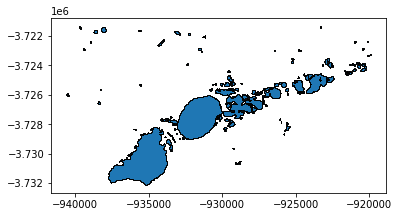

In [41]:
polygons.plot(edgecolor='k')

### Generate a unique ID for each polygon

A unique identifier is required for every polygon to allow it to be referenced. The naming convention for generating unique IDs here is the [geohash](geohash.org).

A Geohash is a geocoding system used to generate short unique identifiers based on latitude/longitude coordinates. It is a short combination of letters and numbers, with the length of the string a function of the precision of the location. The methods for generating a geohash are outlined [here - yes, the official documentation is a wikipedia article](https://en.wikipedia.org/wiki/Geohash).

Here we use the python package `python-geohash` to generate a geohash unique identifier for each polygon. We use `precision = 9` geohash characters, which represents an on the ground accuracy of <20 metres. This ensures that the precision is high enough to differentiate between waterbodies located next to each other.

In [42]:
# We need to convert from Albers coordinates to lat/lon, in order to generate the geohash
polygons_4326 = polygons.to_crs(epsg=4326)

# Generate a geohash for the centroid of each polygon
polygons_4326['UID'] = polygons_4326.apply(lambda x: gh.encode(x.geometry.centroid.y, x.geometry.centroid.x, precision=9), axis=1)

# Check that our unique ID is in fact unique
assert polygons_4326['UID'].is_unique

# Make an arbitrary numerical ID for each polygon. We will first sort the dataframe by geohash
# so that polygons close to each other are numbered similarly
sorted_polygons = polygons_4326.sort_values(by=['UID']).reset_index()
sorted_polygons['WB_ID'] = sorted_polygons.index

In [43]:
# The step above creates an 'index' column, which we don't actually want, so drop it.
sorted_polygons.drop(labels='index', axis=1, inplace=True)

In [44]:
polygons = sorted_polygons.to_crs('EPSG:3577')

### Write out the final results to a shapefile

In [45]:
polygons.to_file(intermediate_wb_path / f'{base_filename}.shp', driver='ESRI Shapefile')
polygons.to_file(intermediate_wb_path / f'{base_filename}.geojson', driver='GeoJSON')

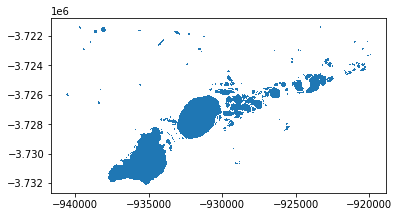

In [46]:
polygons.plot()

## Compare to DEA Waterbodies

In [47]:
wbs = get_waterbodies([xlim[0], ylim[0], xlim[1], ylim[1]])

In [48]:
polygon_raster = xr_rasterize(polygons, wofs)

In [49]:
wbs_raster = xr_rasterize(wbs, wofs)

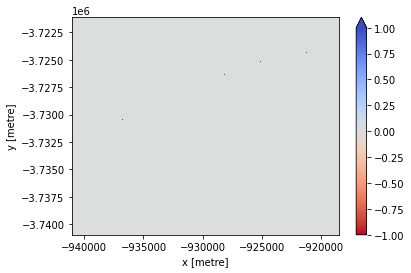

In [50]:
(polygon_raster - wbs_raster).plot(cmap='coolwarm_r', vmin=-1, vmax=1)

If all parameters are set as in v1, this notebook should reproduce DEA Waterbodies. But we can also change these parameters, and experiment with how we might improve DEA Waterbodies for future releases.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:**

In [51]:
datacube.__version__

'1.8.3'

## Tags